In [10]:
%matplotlib inline
import random
import numpy as np
import math as math
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("intrusion.csv")

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X = (X - X.min())/(X.max() - X.min())

In [3]:
def func(z,activation):
    if activation == "sigmoid":
        return 1.0/(1.0+np.exp(-z))
    
    if activation == "tanh":
        return (2.0/(1.0+np.exp(-2*z)) - 1)

    if activation == "relu":
        return np.maximum(z,0)

    if activation == "linear":
        return z

def func_grad(z,activation):
    if activation == "sigmoid":
        return (func(z,activation) * (1 - func(z,activation)))

    if activation == "tanh":
        return (1 - (func(z,activation)**2))

    if activation == "relu":
        z[z<=0] = 0
        z[z>0] = 1
        return z

    if activation == "linear":
        return 1


class Network():
    def __init__(self, no_neurons, activation):
        self.weights    = [np.random.randn(y,x+1)*np.sqrt(2/(x+y+1)) for x, y in zip(no_neurons[:-1], no_neurons[1:])]
        self.no_layers  = len(no_neurons)
        self.no_neurons = no_neurons
        self.activation = activation
        
    def forward_prop(self,X,weights):
        a = [] 
        temp = X.values
        for i in range(len(weights)):
            activation = self.activation            
            temp = np.c_[temp,np.ones(len(temp))]
            a.append(temp)
            temp = func(np.matmul(temp,weights[i].T),activation)

        a.append(temp)
        return a

    def Batch(self,X,y,bs):
        return [X.iloc[i:i+bs,:] for i in range(0,X.shape[0],bs)],[y.iloc[i:i+bs,:] for i in range(0,y.shape[0],bs)]
    
    def backward_prop(self,X,y,weights):
        a     = self.forward_prop(X,weights)
        delta = a[-1] - y
        dW    = (np.matmul(delta.T,a[-2]))/len(y)
        weights[-1] -= 0.01*dW
        for i in range(len(weights)-2,-1,-1):
            delta       = (np.matmul(delta,weights[i+1][:,:-1])) * func_grad(a[i+1][:,:-1],self.activation)
            dW          = np.matmul(delta.T,a[i])/len(y)
            weights[i] -= 0.01*dW
        
        return weights
    
nn = Network([len(X.columns), 15, len(X.columns)],"linear")

no_of_batches = math.ceil(X.shape[1]/32)
weights = nn.weights
accuracy = []

for i in range(100):
    X_batch,y_batch = nn.Batch(X,X,32)
    for k in range(no_of_batches):
        weights = nn.backward_prop(X_batch[k],y_batch[k],weights)
    print("Epoch No:" + str(i))
    a = nn.forward_prop(X,weights)
    accuracy.append(mean_squared_error(a[-1],X))
    print(accuracy[-1])

Epoch No:0
0.32432553458149516
Epoch No:1
0.30431590200054986
Epoch No:2
0.28690416205918856
Epoch No:3
0.27156933745972117
Epoch No:4
0.25792056675013036
Epoch No:5
0.24566002209813864
Epoch No:6
0.23455758577580268
Epoch No:7
0.22443320039715153
Epoch No:8
0.2151443417908734
Epoch No:9
0.20657698140543768
Epoch No:10
0.1986389694395462
Epoch No:11
0.19125512516061446
Epoch No:12
0.18436354942211833
Epoch No:13
0.17791282431464592
Epoch No:14
0.17185986499053676
Epoch No:15
0.1661682566292223
Epoch No:16
0.1608069562868452
Epoch No:17
0.15574927202294644
Epoch No:18
0.15097205477034129
Epoch No:19
0.14645505490869581
Epoch No:20
0.1421804074202457
Epoch No:21
0.13813221820414262
Epoch No:22
0.13429623053457498
Epoch No:23
0.1306595554128746
Epoch No:24
0.12721045313836604
Epoch No:25
0.12393815612761747
Epoch No:26
0.12083272507653828
Epoch No:27
0.1178849321497294
Epoch No:28
0.11508616611676875
Epoch No:29
0.11242835532345749
Epoch No:30
0.10990390515205552
Epoch No:31
0.10750564723

#### Part-2

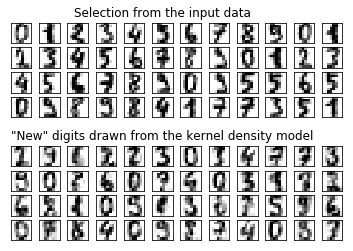

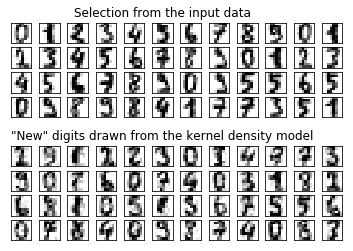

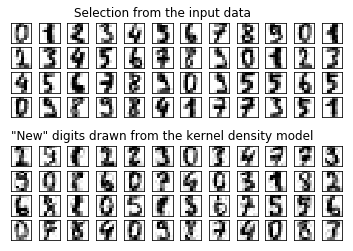

In [7]:
digits = load_digits()

# project the 64-dimensional data to a lower dimension
a = [20,30,40]

for i in a:
    pca = PCA(n_components=i, whiten=False)
    data = pca.fit_transform(digits.data)

    # use grid search cross-validation to optimize the bandwidth
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(data)

    # use the best estimator to compute the kernel density estimate
    kde = grid.best_estimator_

    # sample 44 new points from the data
    new_data = kde.sample(48, random_state=0)
    new_data = pca.inverse_transform(new_data)

    # turn data into a 4x12 grid
    new_data = new_data.reshape((4, 12, -1))
    real_data = digits.data[:48].reshape((4, 12, -1))

    # plot real digits and resampled digits
    fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]))
    for j in range(12):
        ax[4, j].set_visible(False)
        for i in range(4):
            im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)
            im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                     cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)

    ax[0, 5].set_title('Selection from the input data')
    ax[5, 5].set_title('"New" digits drawn from the kernel density model')

    plt.show()

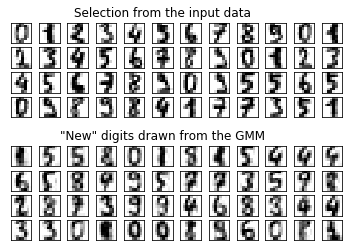

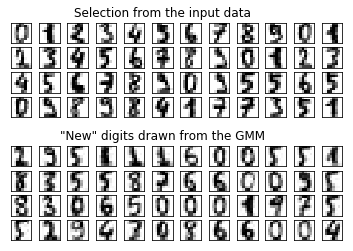

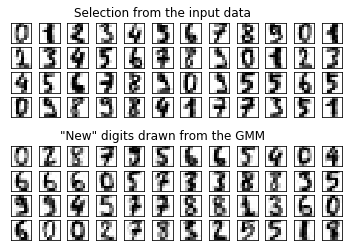

In [27]:
for i in a:
    pca = PCA(n_components=i, whiten=False)
    data = pca.fit_transform(digits.data)

    components = np.arange(50, 400, 20)
    models = [GMM(n, covariance_type='full', random_state=0)
              for n in components]
    aics = [model.fit(data).aic(data) for model in models]
    GMM_Comp = components[np.argmin(aics)]
    
    gmm = GMM(GMM_Comp, covariance_type='full', random_state=0)
    gmm.fit(data)
    
    data_new = gmm.sample(48)
    digits_new = pca.inverse_transform(data_new[0]).reshape((4, 12, -1))
    real_data  = digits.data[:48].reshape((4, 12, -1))

    fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]))
    for j in range(12):
        ax[4, j].set_visible(False)
        for i in range(4):
            im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)
            im = ax[i + 5, j].imshow(digits_new[i, j].reshape((8, 8)),
                                     cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)

    ax[0, 5].set_title('Selection from the input data')
    ax[5, 5].set_title('"New" digits drawn from the GMM')

    plt.show()
